## Parameter estimation of Lorenz Equation using DiffEqBayes.jl

In [1]:
using DiffEqBayes
using Distributions
using DifferentialEquations
using Plots
using ContinuousTransformations

[Turing]: AD chunk size is set as 40



ArgumentError: Module Hiccup not found in current path.
Run `Pkg.add("Hiccup")` to install the Hiccup package.


In [2]:
gr(fmt=:png)

Plots.GRBackend()

#### Initializing the problem

In [3]:
g1 = @ode_def_bare LorenzExample begin
  dx = σ*(y-x)
  dy = x*(ρ-z) - y
  dz = x*y - β*z
end σ ρ β 

(::LorenzExample) (generic function with 2 methods)

In [4]:
r0 = [1.0; 0.0; 0.0]                
tspan = (0.0, 30.0)
p = [10.0,28.0,2.66]

3-element Array{Float64,1}:
 10.0 
 28.0 
  2.66

In [5]:
prob = ODEProblem(g1,r0,tspan,p)
@time sol = solve(prob,Tsit5())

  5.321033 seconds (3.26 M allocations: 184.333 MiB, 1.76% gc time)


retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 357-element Array{Float64,1}:
  0.0        
  3.56786e-5 
  0.000392465
  0.00326234 
  0.00905769 
  0.0169556  
  0.0276884  
  0.0418539  
  0.0602369  
  0.0836807  
  0.113359   
  0.148617   
  0.187037   
  ⋮          
 29.2024     
 29.2868     
 29.3682     
 29.4377     
 29.5106     
 29.5789     
 29.659      
 29.7275     
 29.8105     
 29.907      
 29.9937     
 30.0        
u: 357-element Array{Array{Float64,1},1}:
 [1.0, 0.0, 0.0]                    
 [0.999643, 0.000998805, 1.78143e-8]
 [0.996105, 0.0109654, 2.14696e-6]  
 [0.96936, 0.0897687, 0.000143797]  
 [0.924207, 0.242279, 0.0010461]    
 [0.880049, 0.438715, 0.00342406]   
 [0.848333, 0.691528, 0.0084873]    
 [0.8495, 1.01449, 0.0182119]       
 [0.913889, 1.44248, 0.0366944]     
 [1.08882, 2.05219, 0.074029]       
 [1.46076, 3.02043, 0.160047]       
 [2.1626, 4.63308, 0.37716]         
 [3.36836, 7.26747, 0.93653]        
 ⋮   

#### Generating data for bayesian estimation of parameters from the obtained solutions using the `Tsit5` algorithm by adding random noise to it.

In [6]:
t = collect(linspace(1,30,30))
sig = 0.49
data = convert(Array, VectorOfArray([(sol(t[i]) + sig*randn(3)) for i in 1:length(t)]))

3×30 Array{Float64,2}:
 -9.58145  -7.88257  -7.66149  -8.40282  …  -10.1673   -3.74927  -13.234 
 -8.76609  -8.58261  -6.48106  -9.50345      -6.25492  -4.36046  -18.8178
 27.8372   24.7711   27.9534   26.6351       34.7228   18.0028    26.4276

#### Plots of the generated data and the actual data.


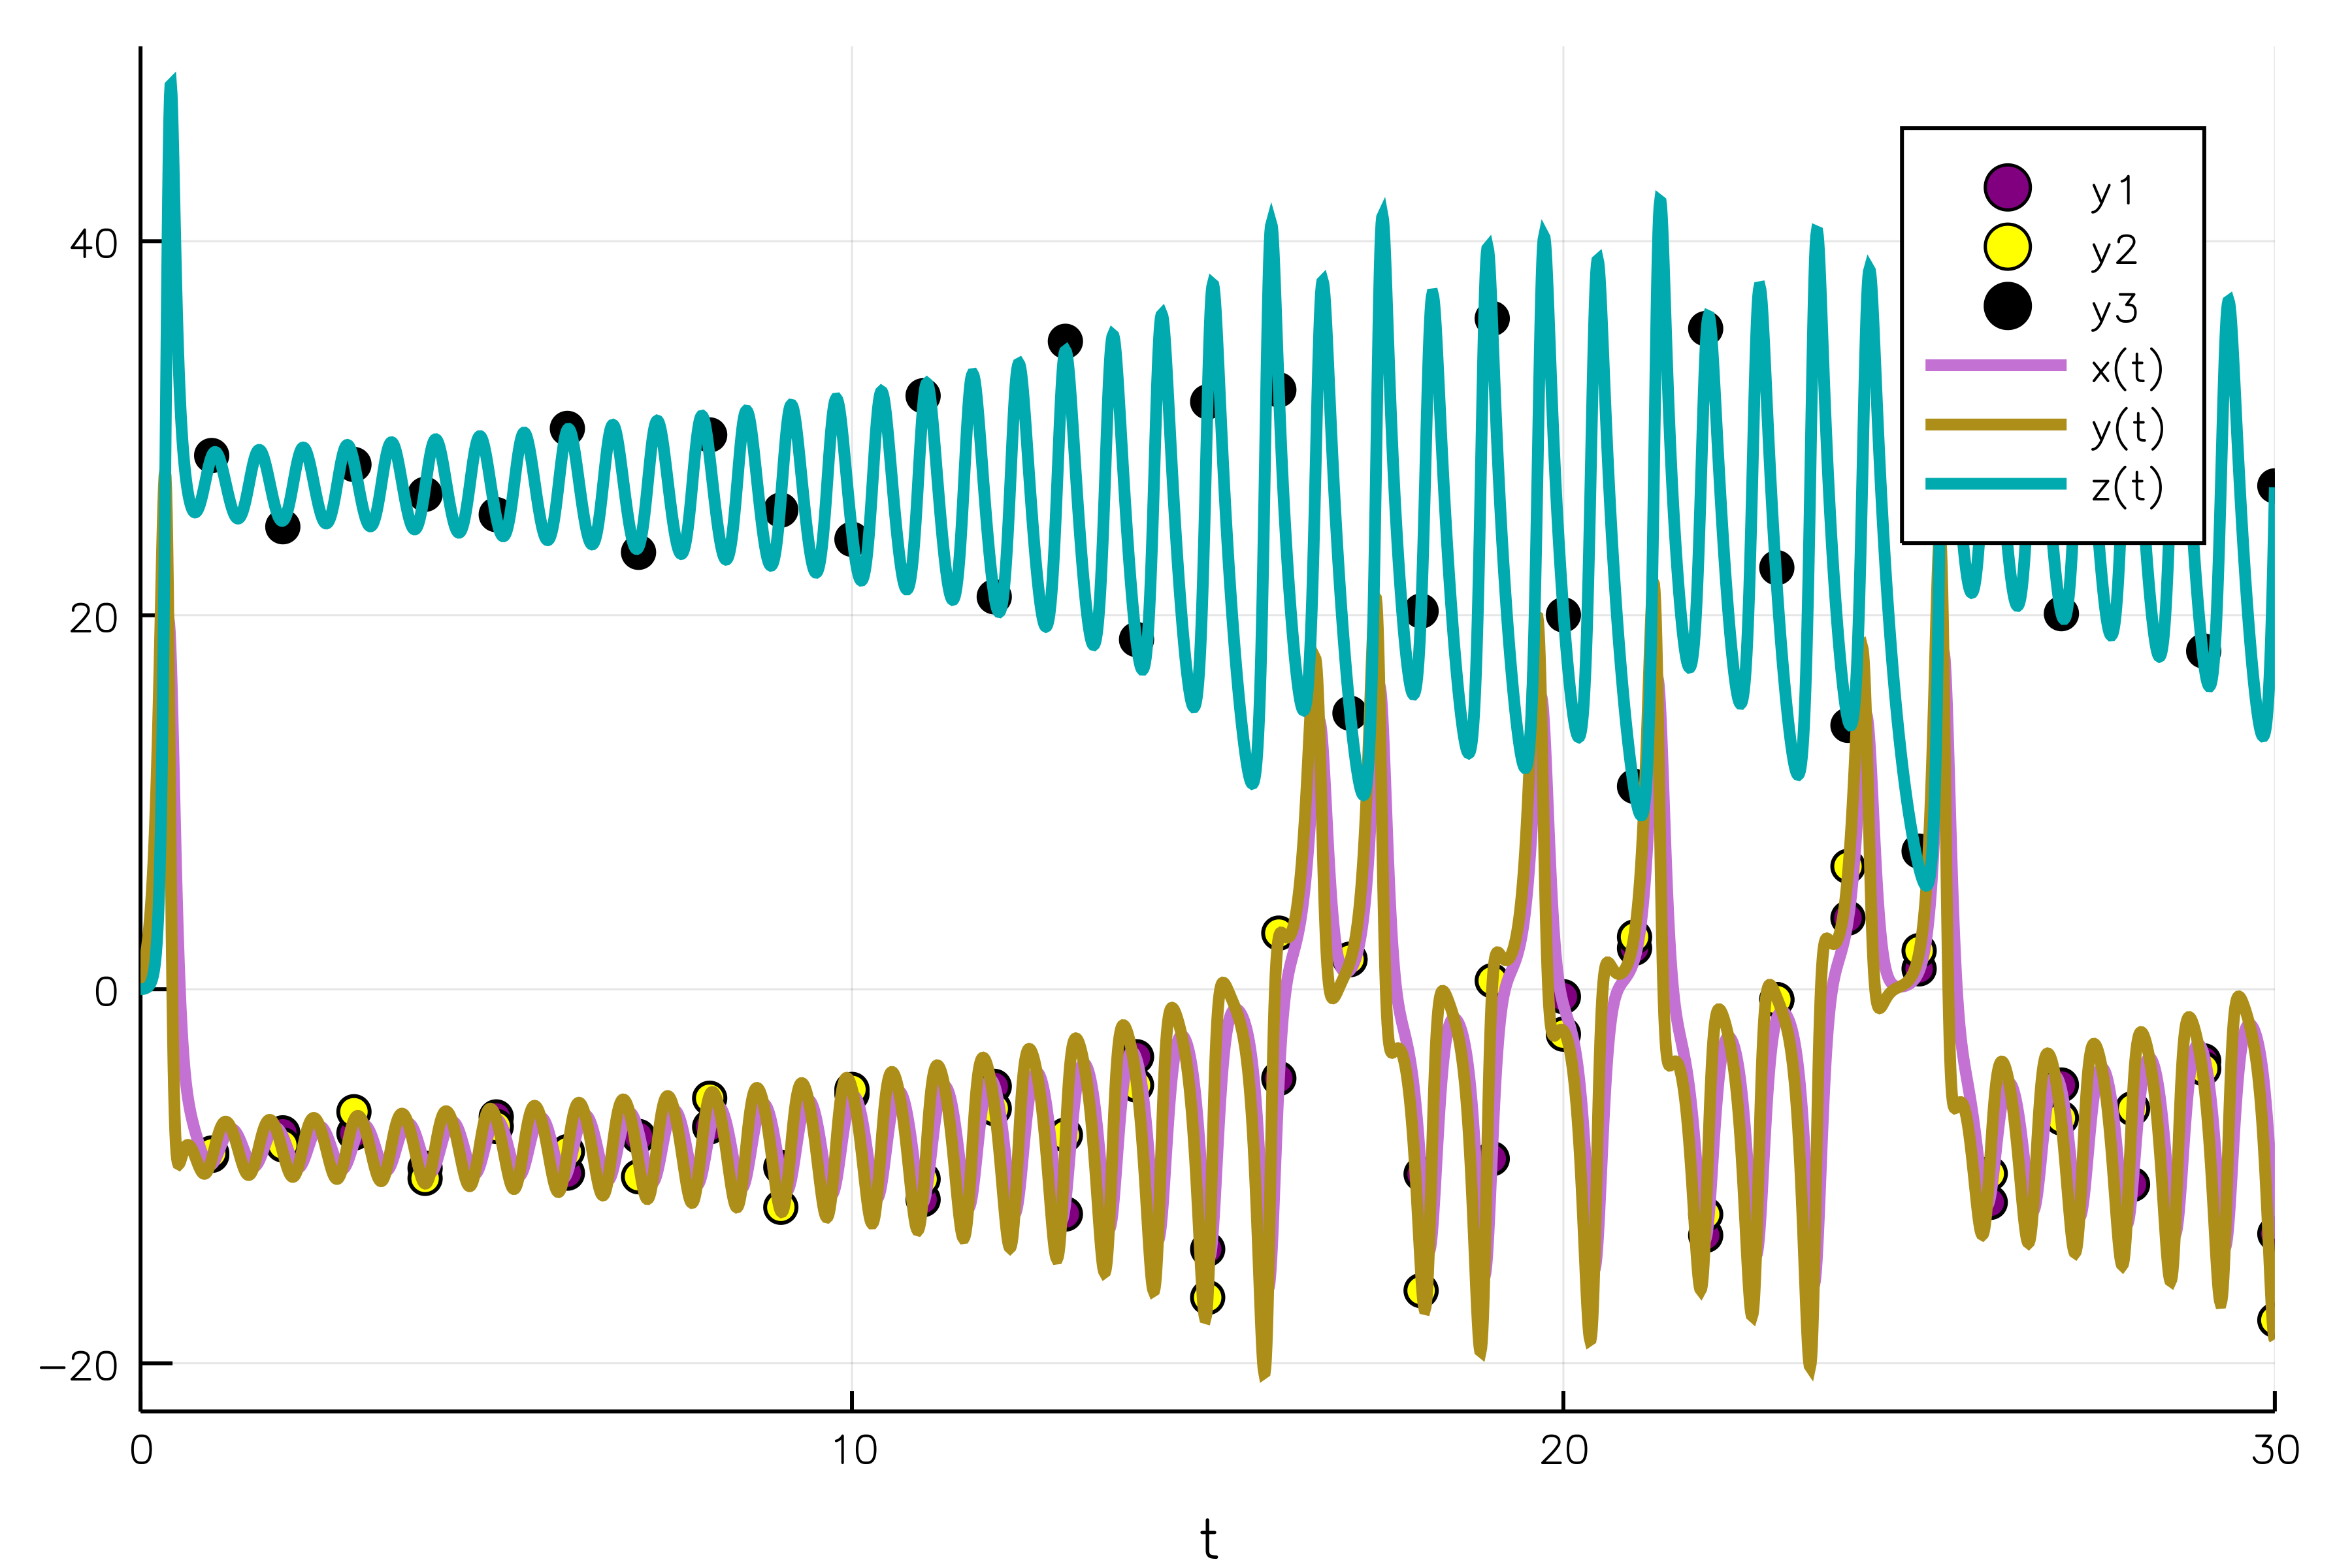

In [7]:
Plots.scatter(t, data[1,:],markersize=4,color=:purple)
Plots.scatter!(t, data[2,:],markersize=4,color=:yellow)
Plots.scatter!(t, data[3,:],markersize=4,color=:black)
plot!(sol)

#### Uncertainity Quantification plot is used to decide the tolerance for the differential equation.


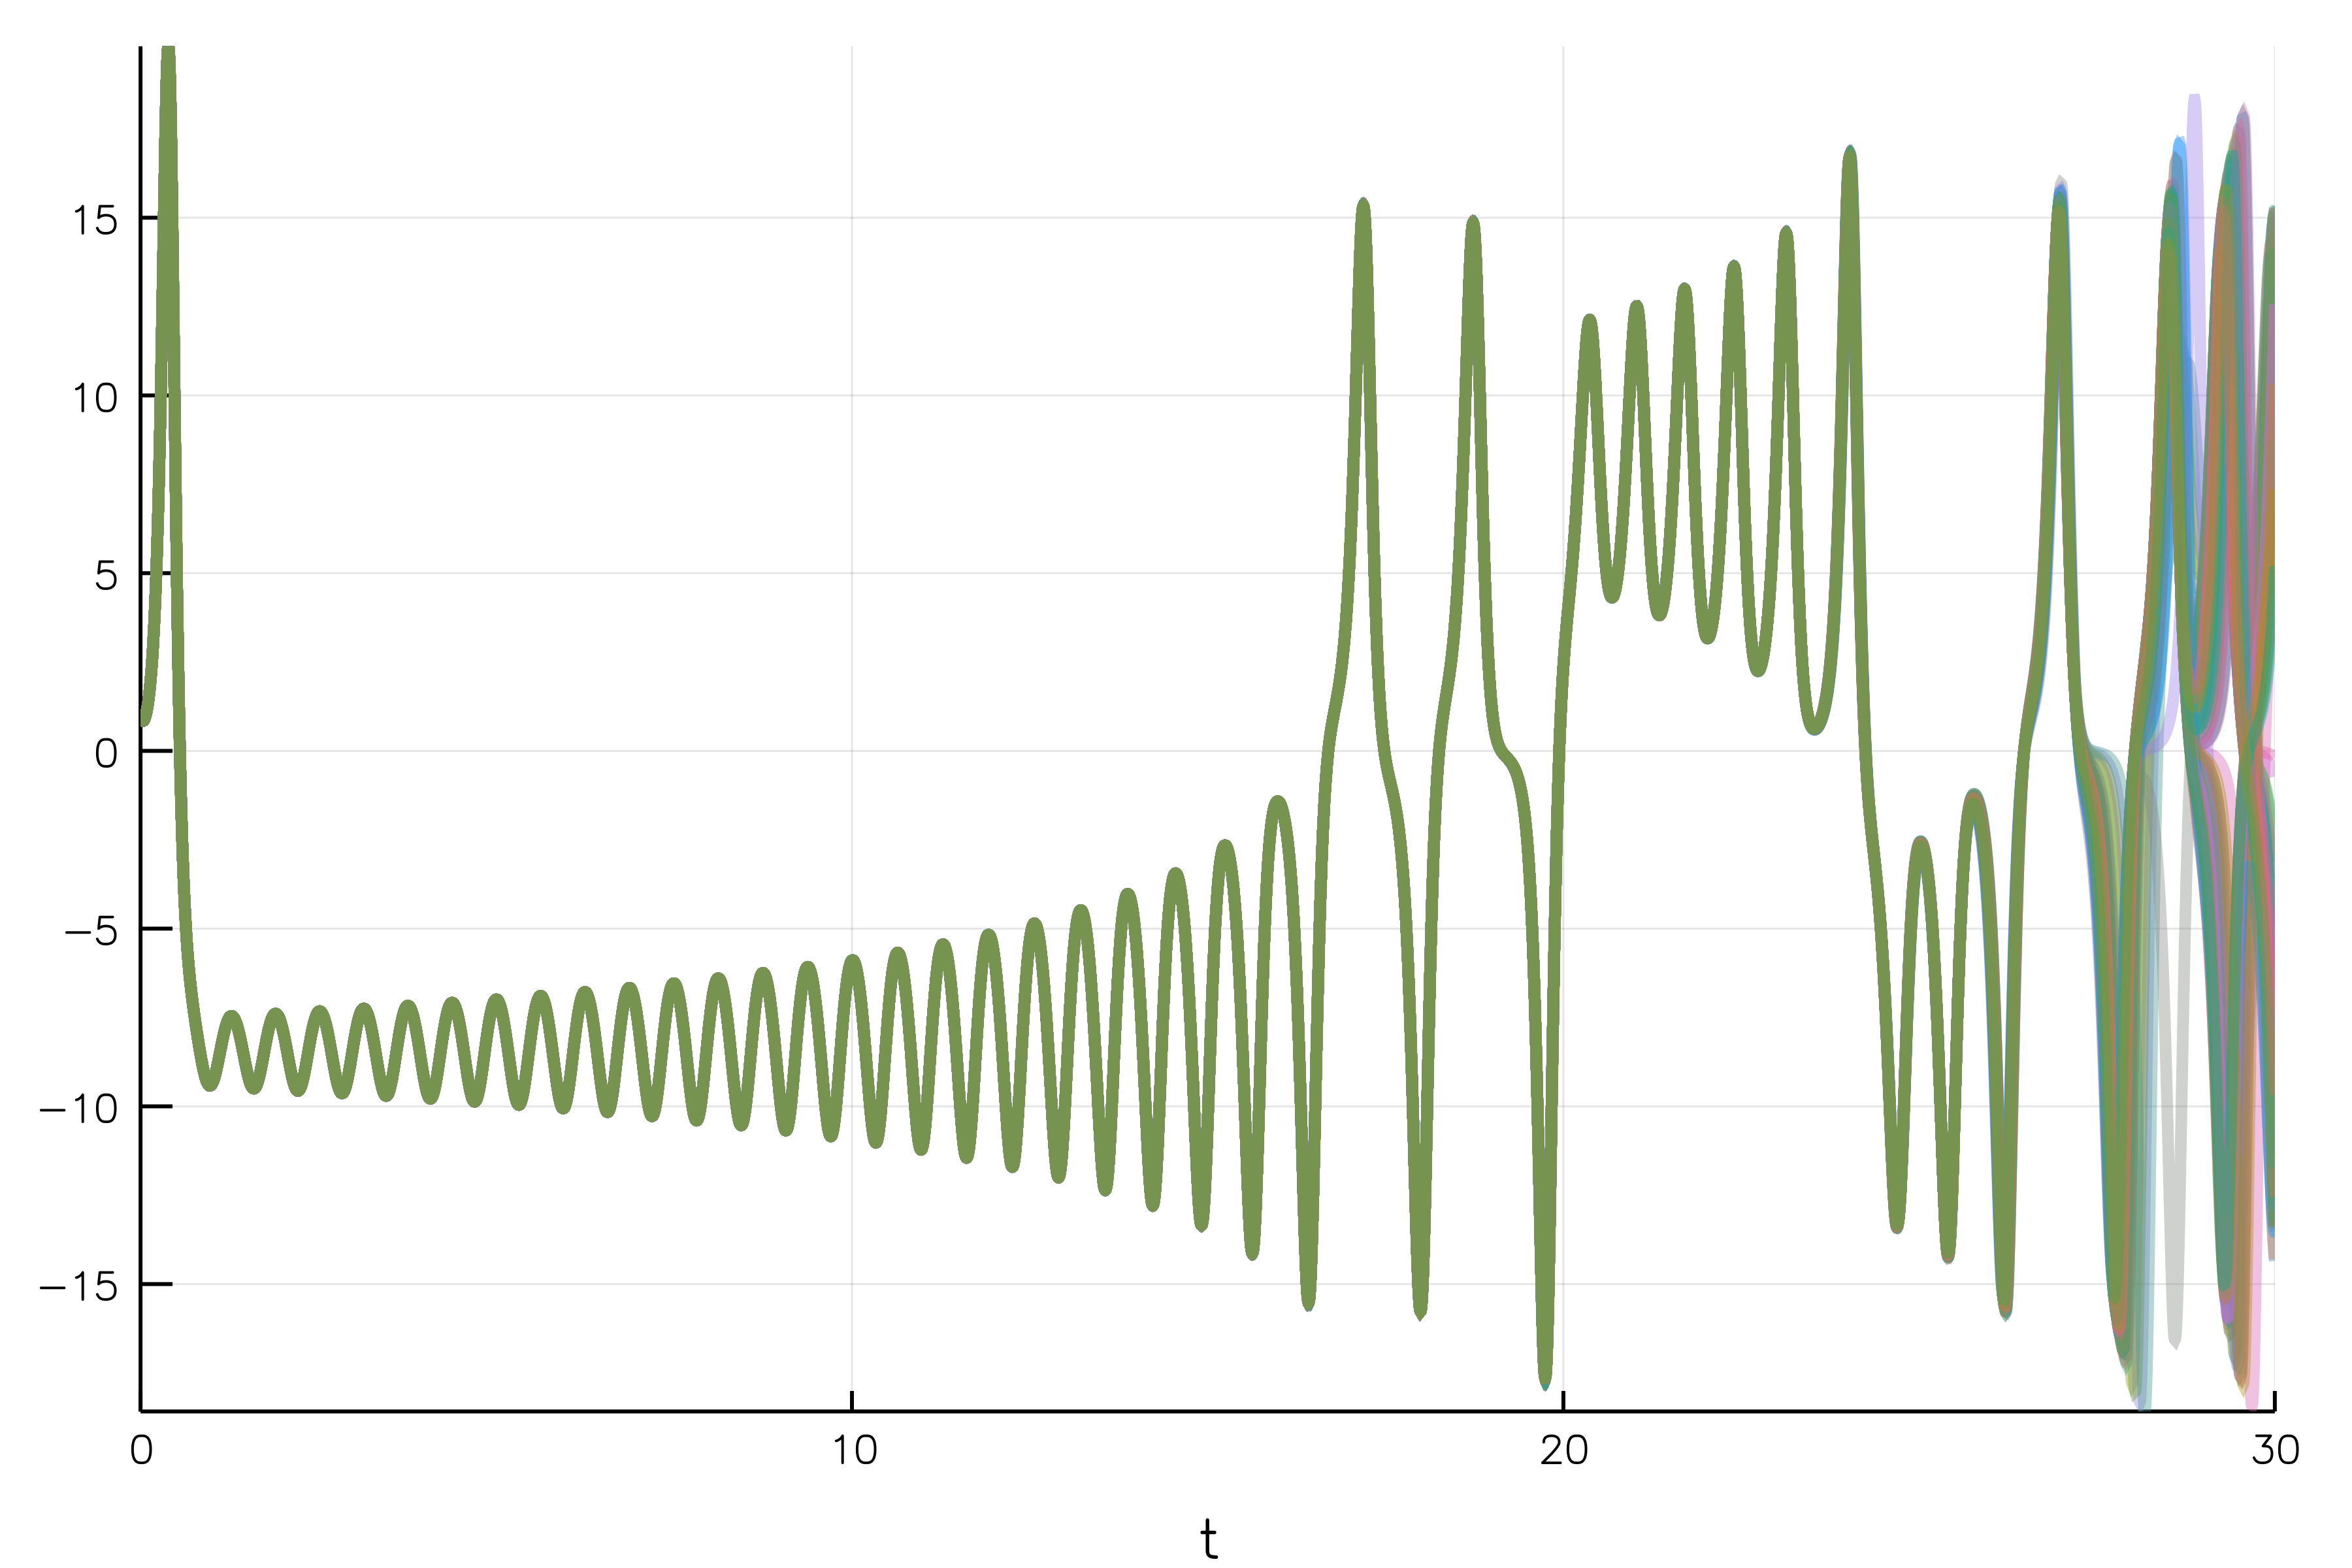

In [8]:
cb = AdaptiveProbIntsUncertainty(5)
monte_prob = MonteCarloProblem(prob)
sim = solve(monte_prob,Tsit5(),num_monte=100,callback=cb,reltol=1e-5,abstol=1e-5)
plot(sim,vars=(0,1),linealpha=0.4)


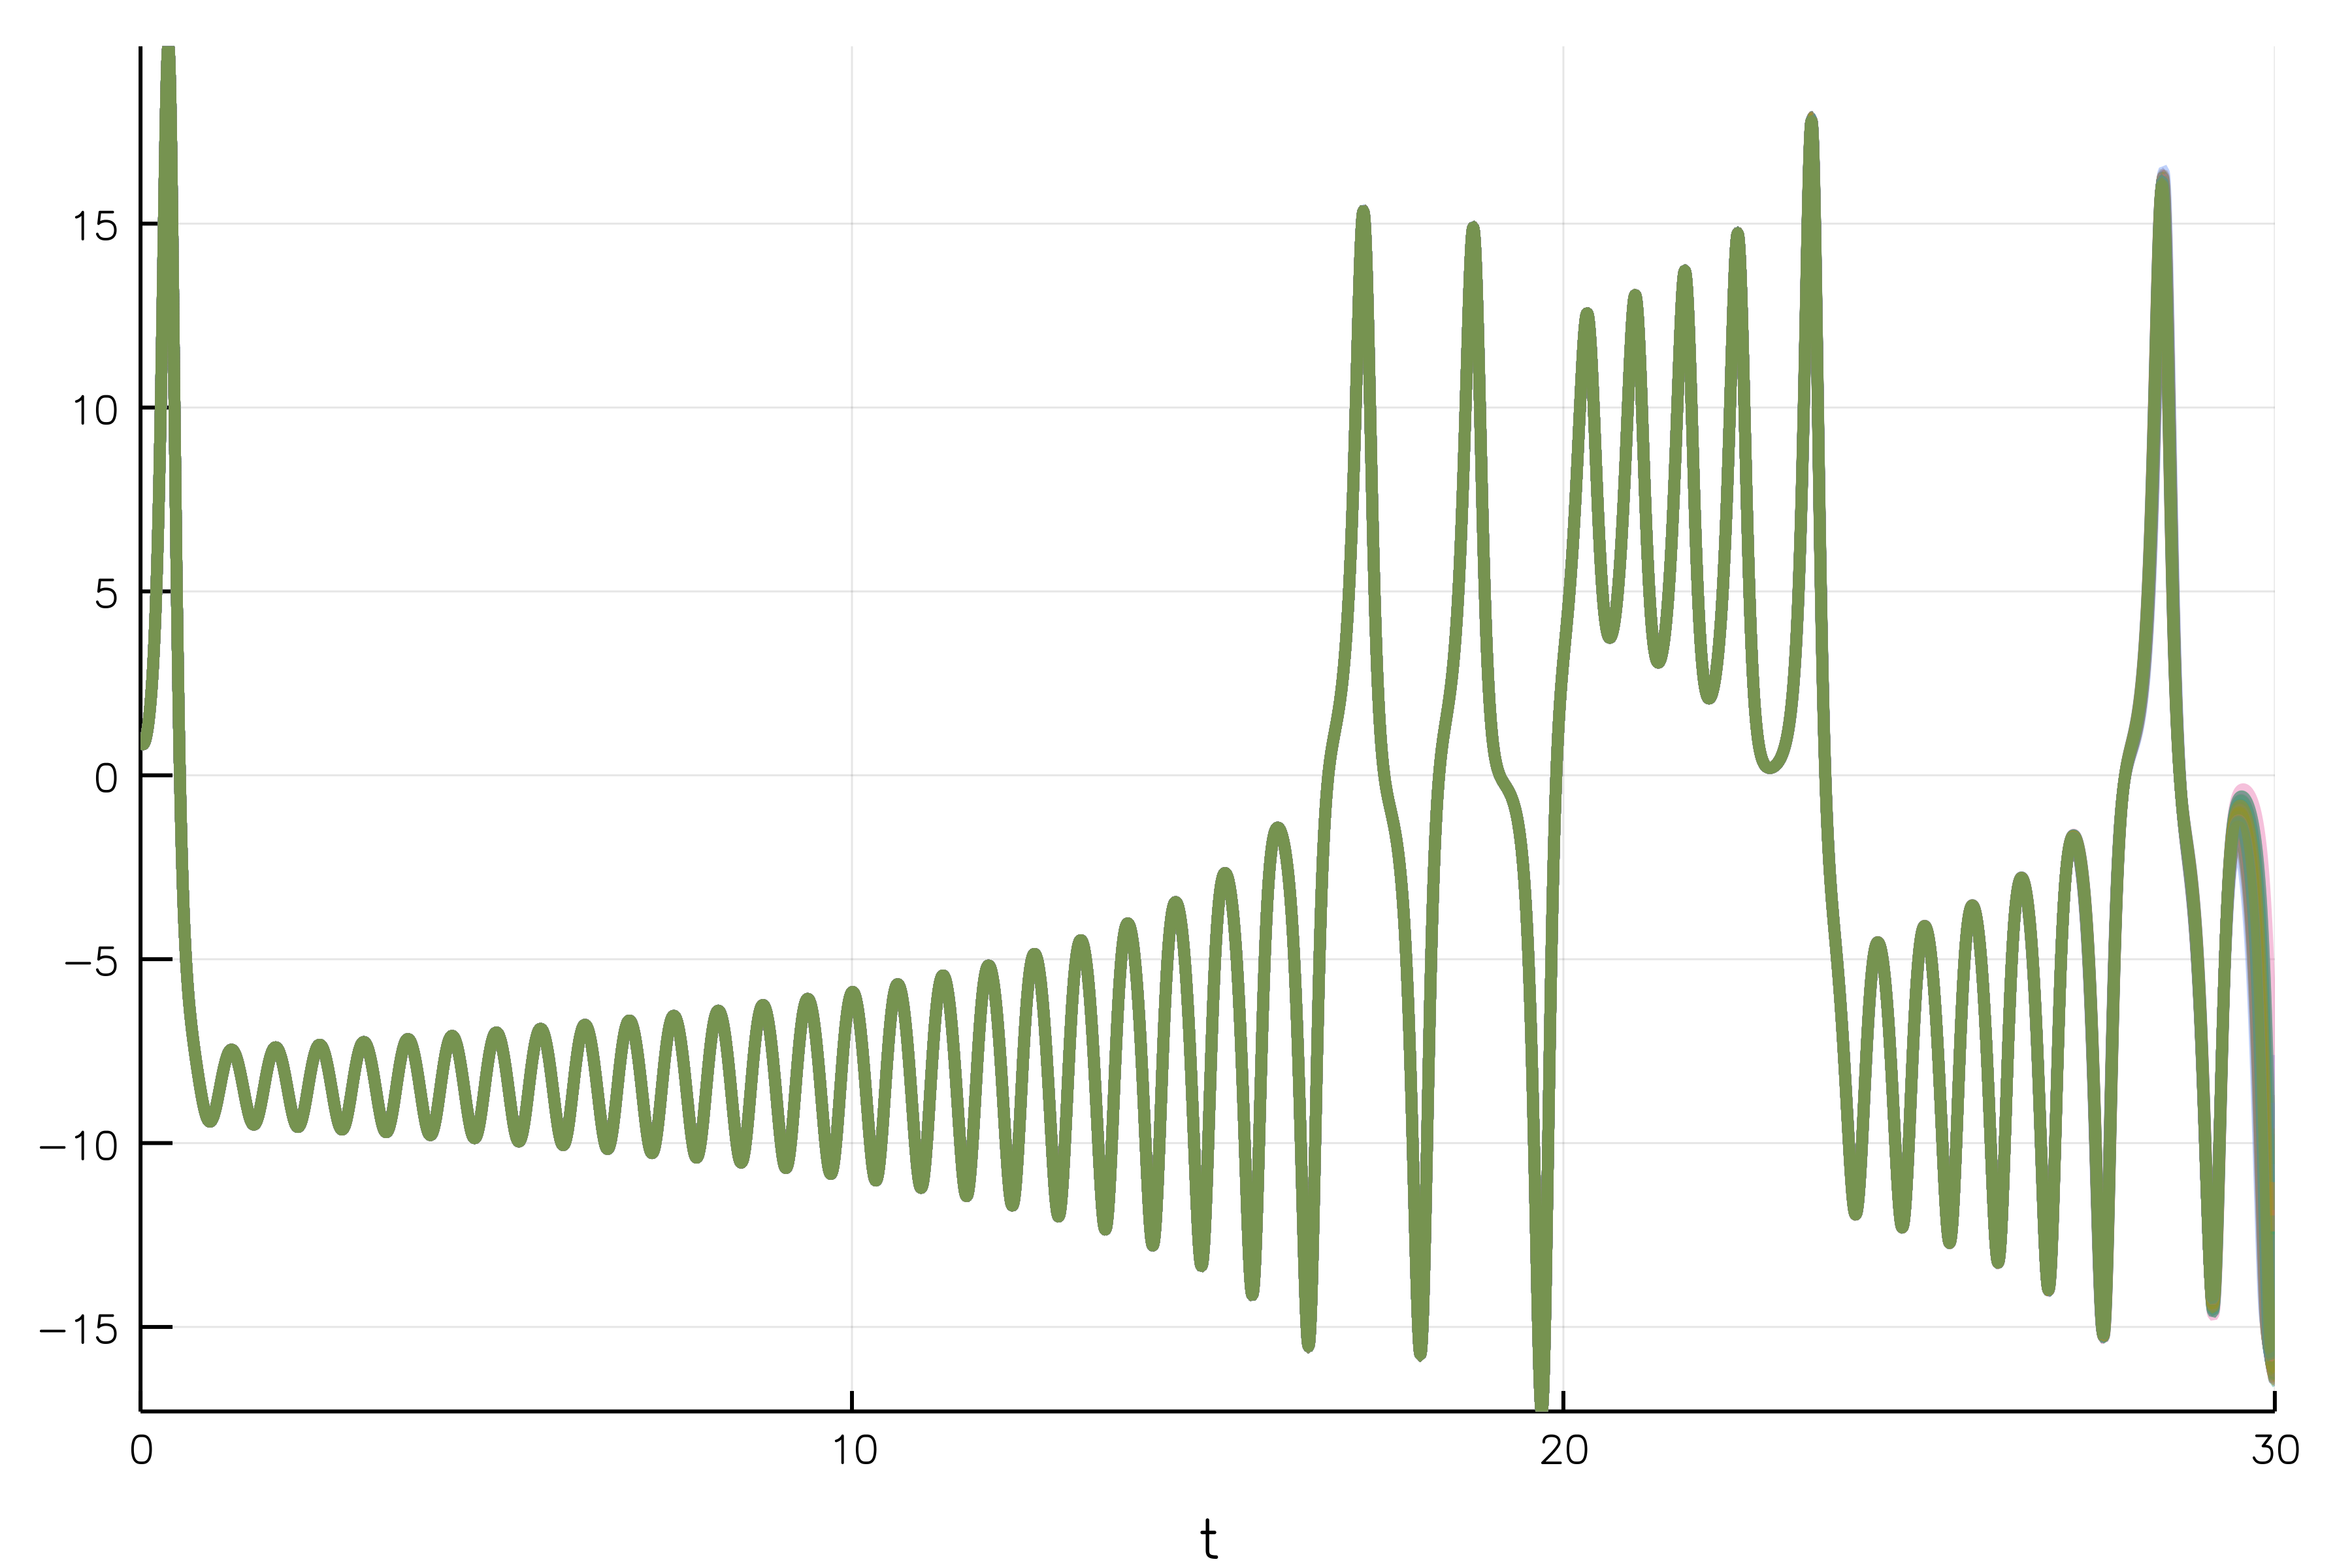

In [9]:
cb = AdaptiveProbIntsUncertainty(5)
monte_prob = MonteCarloProblem(prob)
sim = solve(monte_prob,Tsit5(),num_monte=100,callback=cb,reltol=1e-6,abstol=1e-6)
plot(sim,vars=(0,1),linealpha=0.4)


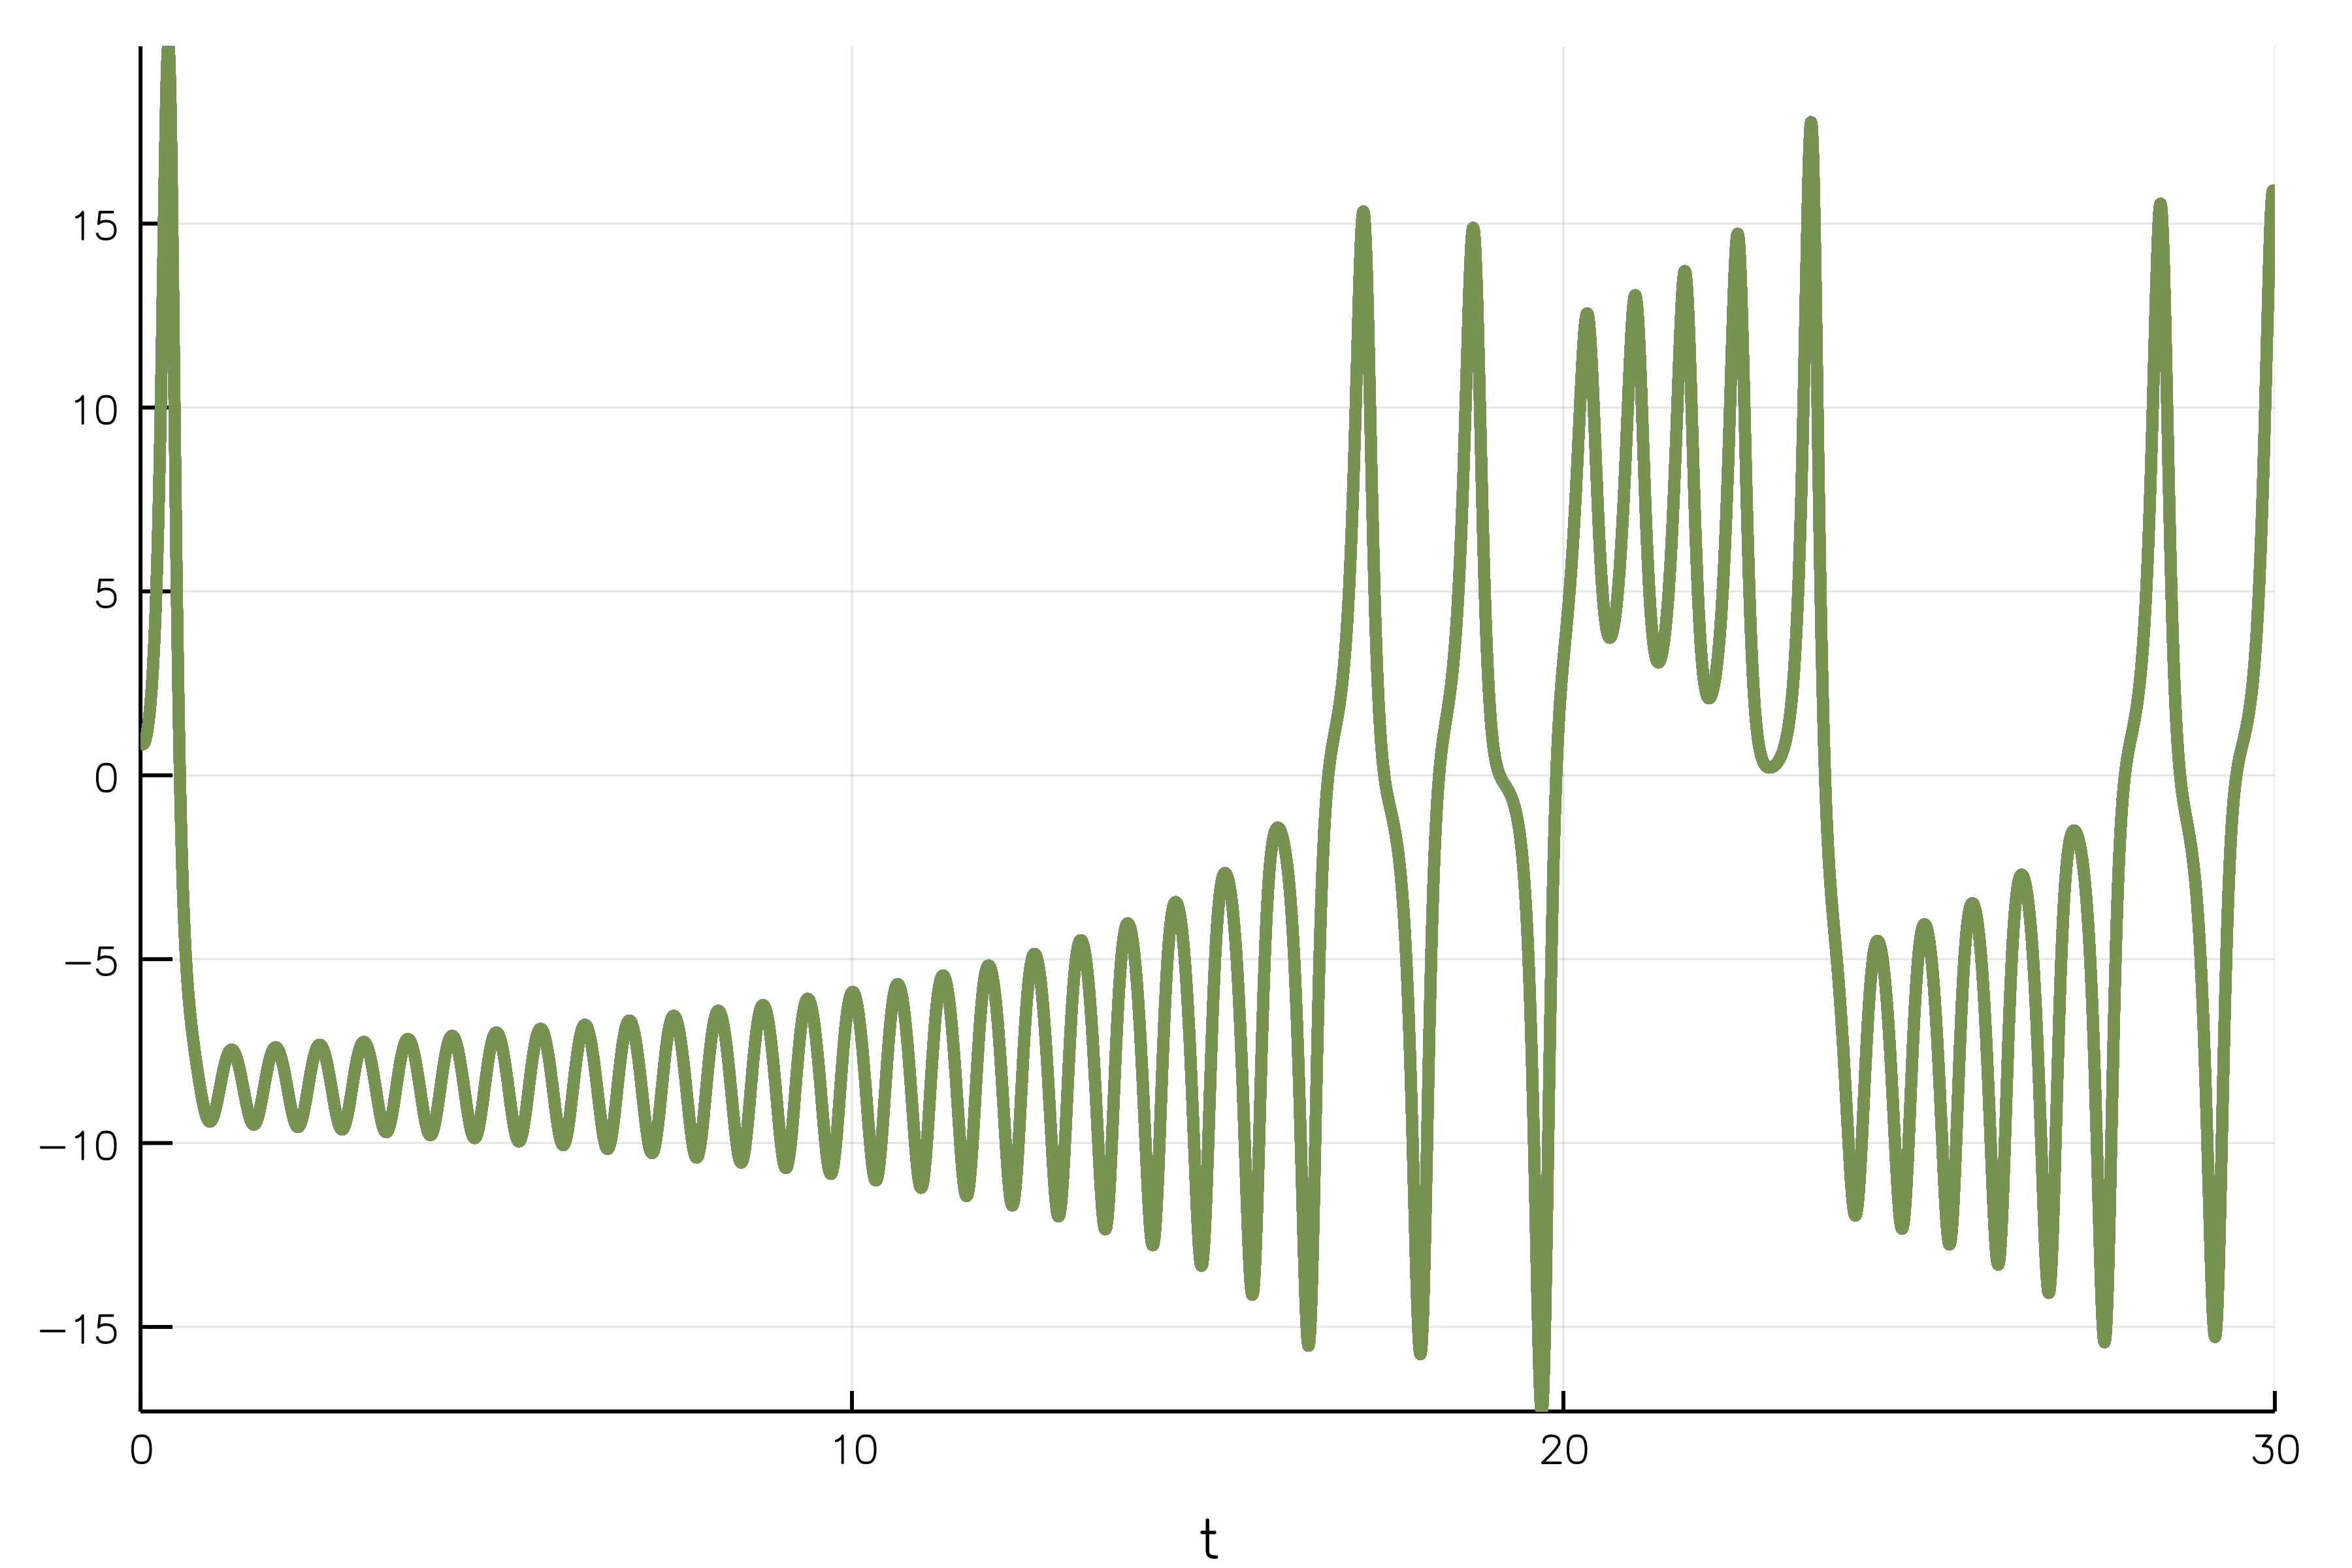

In [10]:
cb = AdaptiveProbIntsUncertainty(5)
monte_prob = MonteCarloProblem(prob)
sim = solve(monte_prob,Tsit5(),num_monte=100,callback=cb,reltol=1e-8,abstol=1e-8)
plot(sim,vars=(0,1),linealpha=0.4)

In [11]:
priors = [Truncated(Normal(10,2),1,15),Truncated(Normal(30,5),1,45),Truncated(Normal(2.5,0.5),1,4)]

3-element Array{Distributions.Truncated{Distributions.Normal{Float64},Distributions.Continuous},1}:
 Truncated(Distributions.Normal{Float64}(μ=10.0, σ=2.0), range=(1.0, 15.0))
 Truncated(Distributions.Normal{Float64}(μ=30.0, σ=5.0), range=(1.0, 45.0))
 Truncated(Distributions.Normal{Float64}(μ=2.5, σ=0.5), range=(1.0, 4.0))  

## Parameter Estimation using Stan.jl backend.

Lorenz equation is a chaotic system hence requires very low tolerance to be estimated in a reasonable way, we use 1e-8 obtained from the uncertainity plots. Use of Truncated priors is necessary to prevent Stan from stepping into negative and other improbable areas.

In [12]:
@time bayesian_result = stan_inference(prob,t,data,priors;num_samples=100,num_warmup=500,reltol=1e-8,abstol=1e-8,vars =(StanODEData(),InverseGamma(3,2)))


File /home/vaibhav/DiffEqBenchmarks.jl/ParameterEstimation/tmp/parameter_estimation_model.stan will be updated.



--- Translating Stan model to C++ code ---
bin/stanc  /home/vaibhav/DiffEqBenchmarks.jl/ParameterEstimation/tmp/parameter_estimation_model.stan --o=/home/vaibhav/DiffEqBenchmarks.jl/ParameterEstimation/tmp/parameter_estimation_model.hpp
Model name=parameter_estimation_model_model
Input file=/home/vaibhav/DiffEqBenchmarks.jl/ParameterEstimation/tmp/parameter_estimation_model.stan
Output file=/home/vaibhav/DiffEqBenchmarks.jl/ParameterEstimation/tmp/parameter_estimation_model.hpp

--- Linking C++ model ---
g++ -I src -I stan/src -isystem stan/lib/stan_math/ -isystem stan/lib/stan_math/lib/eigen_3.3.3 -isystem stan/lib/stan_math/lib/boost_1.62.0 -isystem stan/lib/stan_math/lib/cvodes_2.9.0/include -Wall -DEIGEN_NO_DEBUG  -DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -DFUSION_MAX_VECTOR_SIZE=12 -DNO_FPRINTF_OUTPUT -pipe   -lpthread  -O3 -o /home/vaibha

DiffEqBayes.StanModel{Int64,Mamba.Chains}(0, Object of type "Mamba.Chains"

Iterations = 1:100
Thinning interval = 1
Chains = 1,2,3,4
Samples per chain = 100

[-3984.35 0.980851 … 27.2099 1.43221; -3984.64 0.970424 … 27.2099 1.43221; … ; -3984.16 0.986496 … 27.2099 1.43221; -3984.19 0.997365 … 27.2099 1.43221]

[-212.766 0.873694 … 24.4913 2.01816; -214.908 0.967666 … 24.642 1.99443; … ; -215.39 0.958183 … 24.7421 1.95956; -215.601 0.817682 … 24.7451 1.93742]

[-219.046 0.894935 … 24.4164 2.62147; -220.193 0.987775 … 24.606 2.58852; … ; -220.803 0.936111 … 24.3894 2.68822; -219.935 0.966802 … 24.6509 2.53643]

[-11700.2 0.916027 … 36.2093 3.64159; -11700.2 0.546653 … 36.2093 3.64159; … ; -11700.2 0.557973 … 36.2093 3.64159; -11700.2 0.615872 … 36.2093 3.64159])

In [13]:
Mamba.describe(bayesian_result.chain_results)

Iterations = 1:100
Thinning interval = 1
Chains = 1,2,3,4
Samples per chain = 100

Empirical Posterior Estimates:
                    Mean            SD         Naive SE         MCSE          ESS    
         lp__ -4030.233722500 4693.52258566 234.6761292832 2706.416997323   3.0075191
accept_stat__     0.864699153    0.17381396   0.0086906979    0.048708146  12.7340367
   stepsize__     0.021004684    0.02288015   0.0011440075    0.013193338   3.0075188
  treedepth__     7.960000000    2.15755361   0.1078776807    1.194298958   3.2636012
 n_leapfrog__   553.885000000  469.87413851  23.4937069255  270.460806572   3.0182444
  divergent__     0.007500000    0.08638522   0.0043192609    0.007500000 100.0000000
     energy__  4033.263442500 4693.51572407 234.6757862037 2706.412836605   3.0075196
     sigma1.1     2.944261245    1.63737825   0.0818689126    0.915775192   3.1968355
     sigma1.2     5.555327875    0.66731995   0.0333659976    0.207741815  10.3185905
     sigma1.3     4.478884

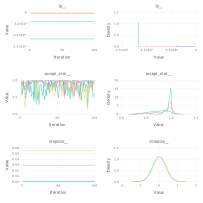

Press ENTER to draw next plot
STDIN> 


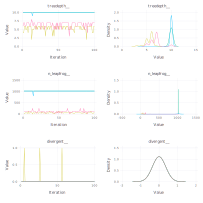

Press ENTER to draw next plot
STDIN> 


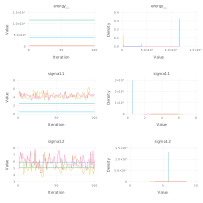

Press ENTER to draw next plot
STDIN> 


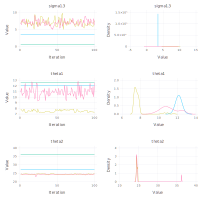

Press ENTER to draw next plot
STDIN> 


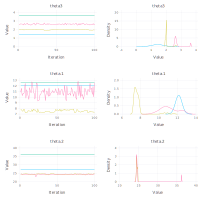

Press ENTER to draw next plot
STDIN> 


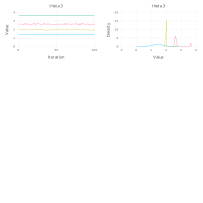

In [14]:
plot_chain(bayesian_result)

### Parameter estimation using DynamicHMC.jl backend

In [12]:
@time bayesian_result = dynamichmc_inference(prob, data, priors, t, [bridge(ℝ, ℝ⁺, ),bridge(ℝ, ℝ⁺, ),bridge(ℝ, ℝ⁺, )];initial=[10.0,30.0,2.5])

229.510746 seconds (497.24 M allocations: 45.774 GiB, 5.20% gc time)


(([8.70859, 8.70863, 8.70852, 8.70855, 8.70854, 8.70854, 8.70862, 8.70862, 8.7086, 8.70861  …  8.70841, 8.70842, 8.7084, 8.70851, 8.70852, 8.70852, 8.7085, 8.70852, 8.70843, 8.70842], [24.8267, 24.8265, 24.8266, 24.8265, 24.8264, 24.8264, 24.8264, 24.8264, 24.8264, 24.8263  …  24.8266, 24.8265, 24.8266, 24.8264, 24.8263, 24.8263, 24.8266, 24.8266, 24.8267, 24.8266], [2.94462, 2.94462, 2.9446, 2.9446, 2.9446, 2.9446, 2.94461, 2.94461, 2.94461, 2.94461  …  2.94458, 2.94458, 2.94458, 2.94459, 2.94459, 2.94459, 2.9446, 2.9446, 2.94459, 2.94458]), DynamicHMC.NUTS_Transition{Array{Float64,1},Float64}[DynamicHMC.NUTS_Transition{Array{Float64,1},Float64}([2.16431, 3.21192, 1.07998], -1.68684e7, 5, MaxDepth, 0.910922, 31), DynamicHMC.NUTS_Transition{Array{Float64,1},Float64}([2.16431, 3.21191, 1.07998], -1.68684e7, 5, MaxDepth, 0.955909, 31), DynamicHMC.NUTS_Transition{Array{Float64,1},Float64}([2.1643, 3.21192, 1.07997], -1.68684e7, 5, MaxDepth, 0.876697, 31), DynamicHMC.NUTS_Transition{Array{

In [16]:
DynamicHMC.NUTS_statistics(bayesian_result[2]),bayesian_result[3],mean(bayesian_result[1][1]),mean(bayesian_result[1][2]),mean(bayesian_result[1][3])

(Hamiltonian Monte Carlo sample of length 1000
  acceptance rate mean: 0.9, min/25%/median/75%/max: 0.47 0.86 0.92 0.97 1.0
  termination: MaxDepth => 70% AdjacentTurn => 17% DoubledTurn => 13%
  depth: 1 => 1% 2 => 10% 3 => 6% 4 => 9% 5 => 74%
, NUTS sampler in 3 dimensions
  stepsize (ϵ) ≈ 0.0415
  maximum depth = 5
  Gaussian kinetic energy, √diag(M⁻¹): [5.99773e-6, 7.23697e-6, 3.03945e-6]
, 8.708474964482495, 24.826599103609336, 2.9445917347232085)


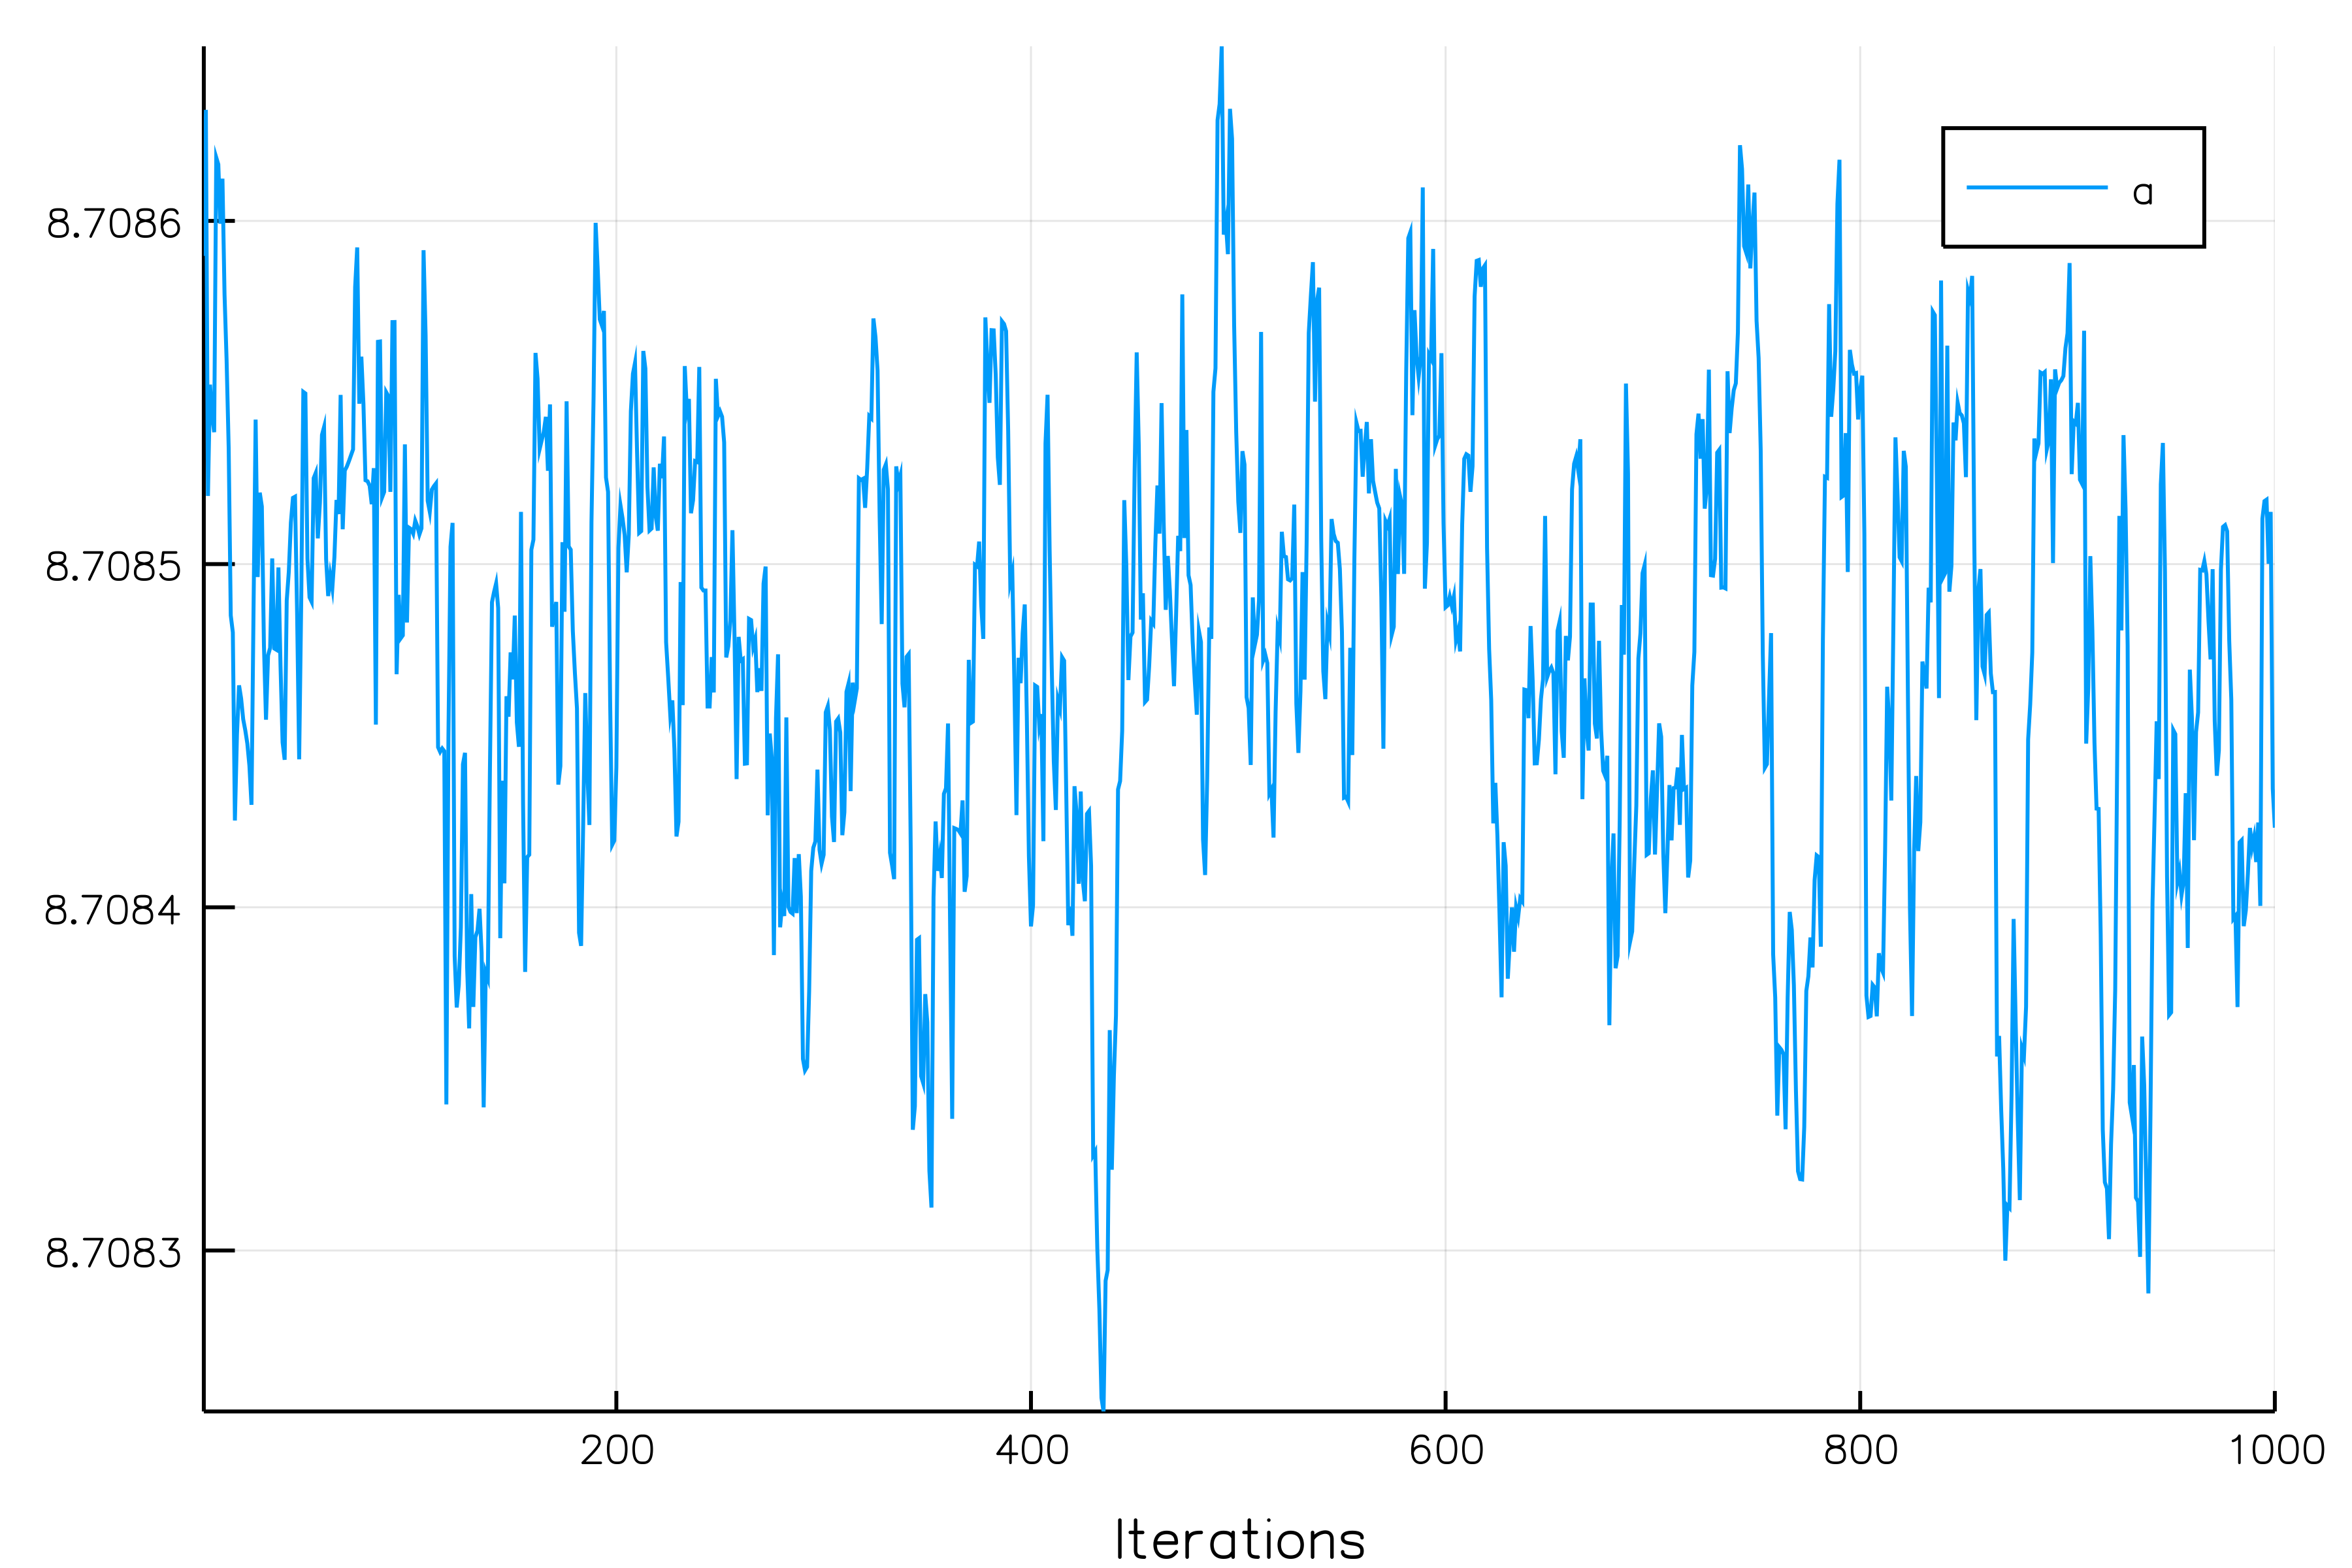

In [23]:
plot(bayesian_result[1][1], label="a", xlab= "Iterations")


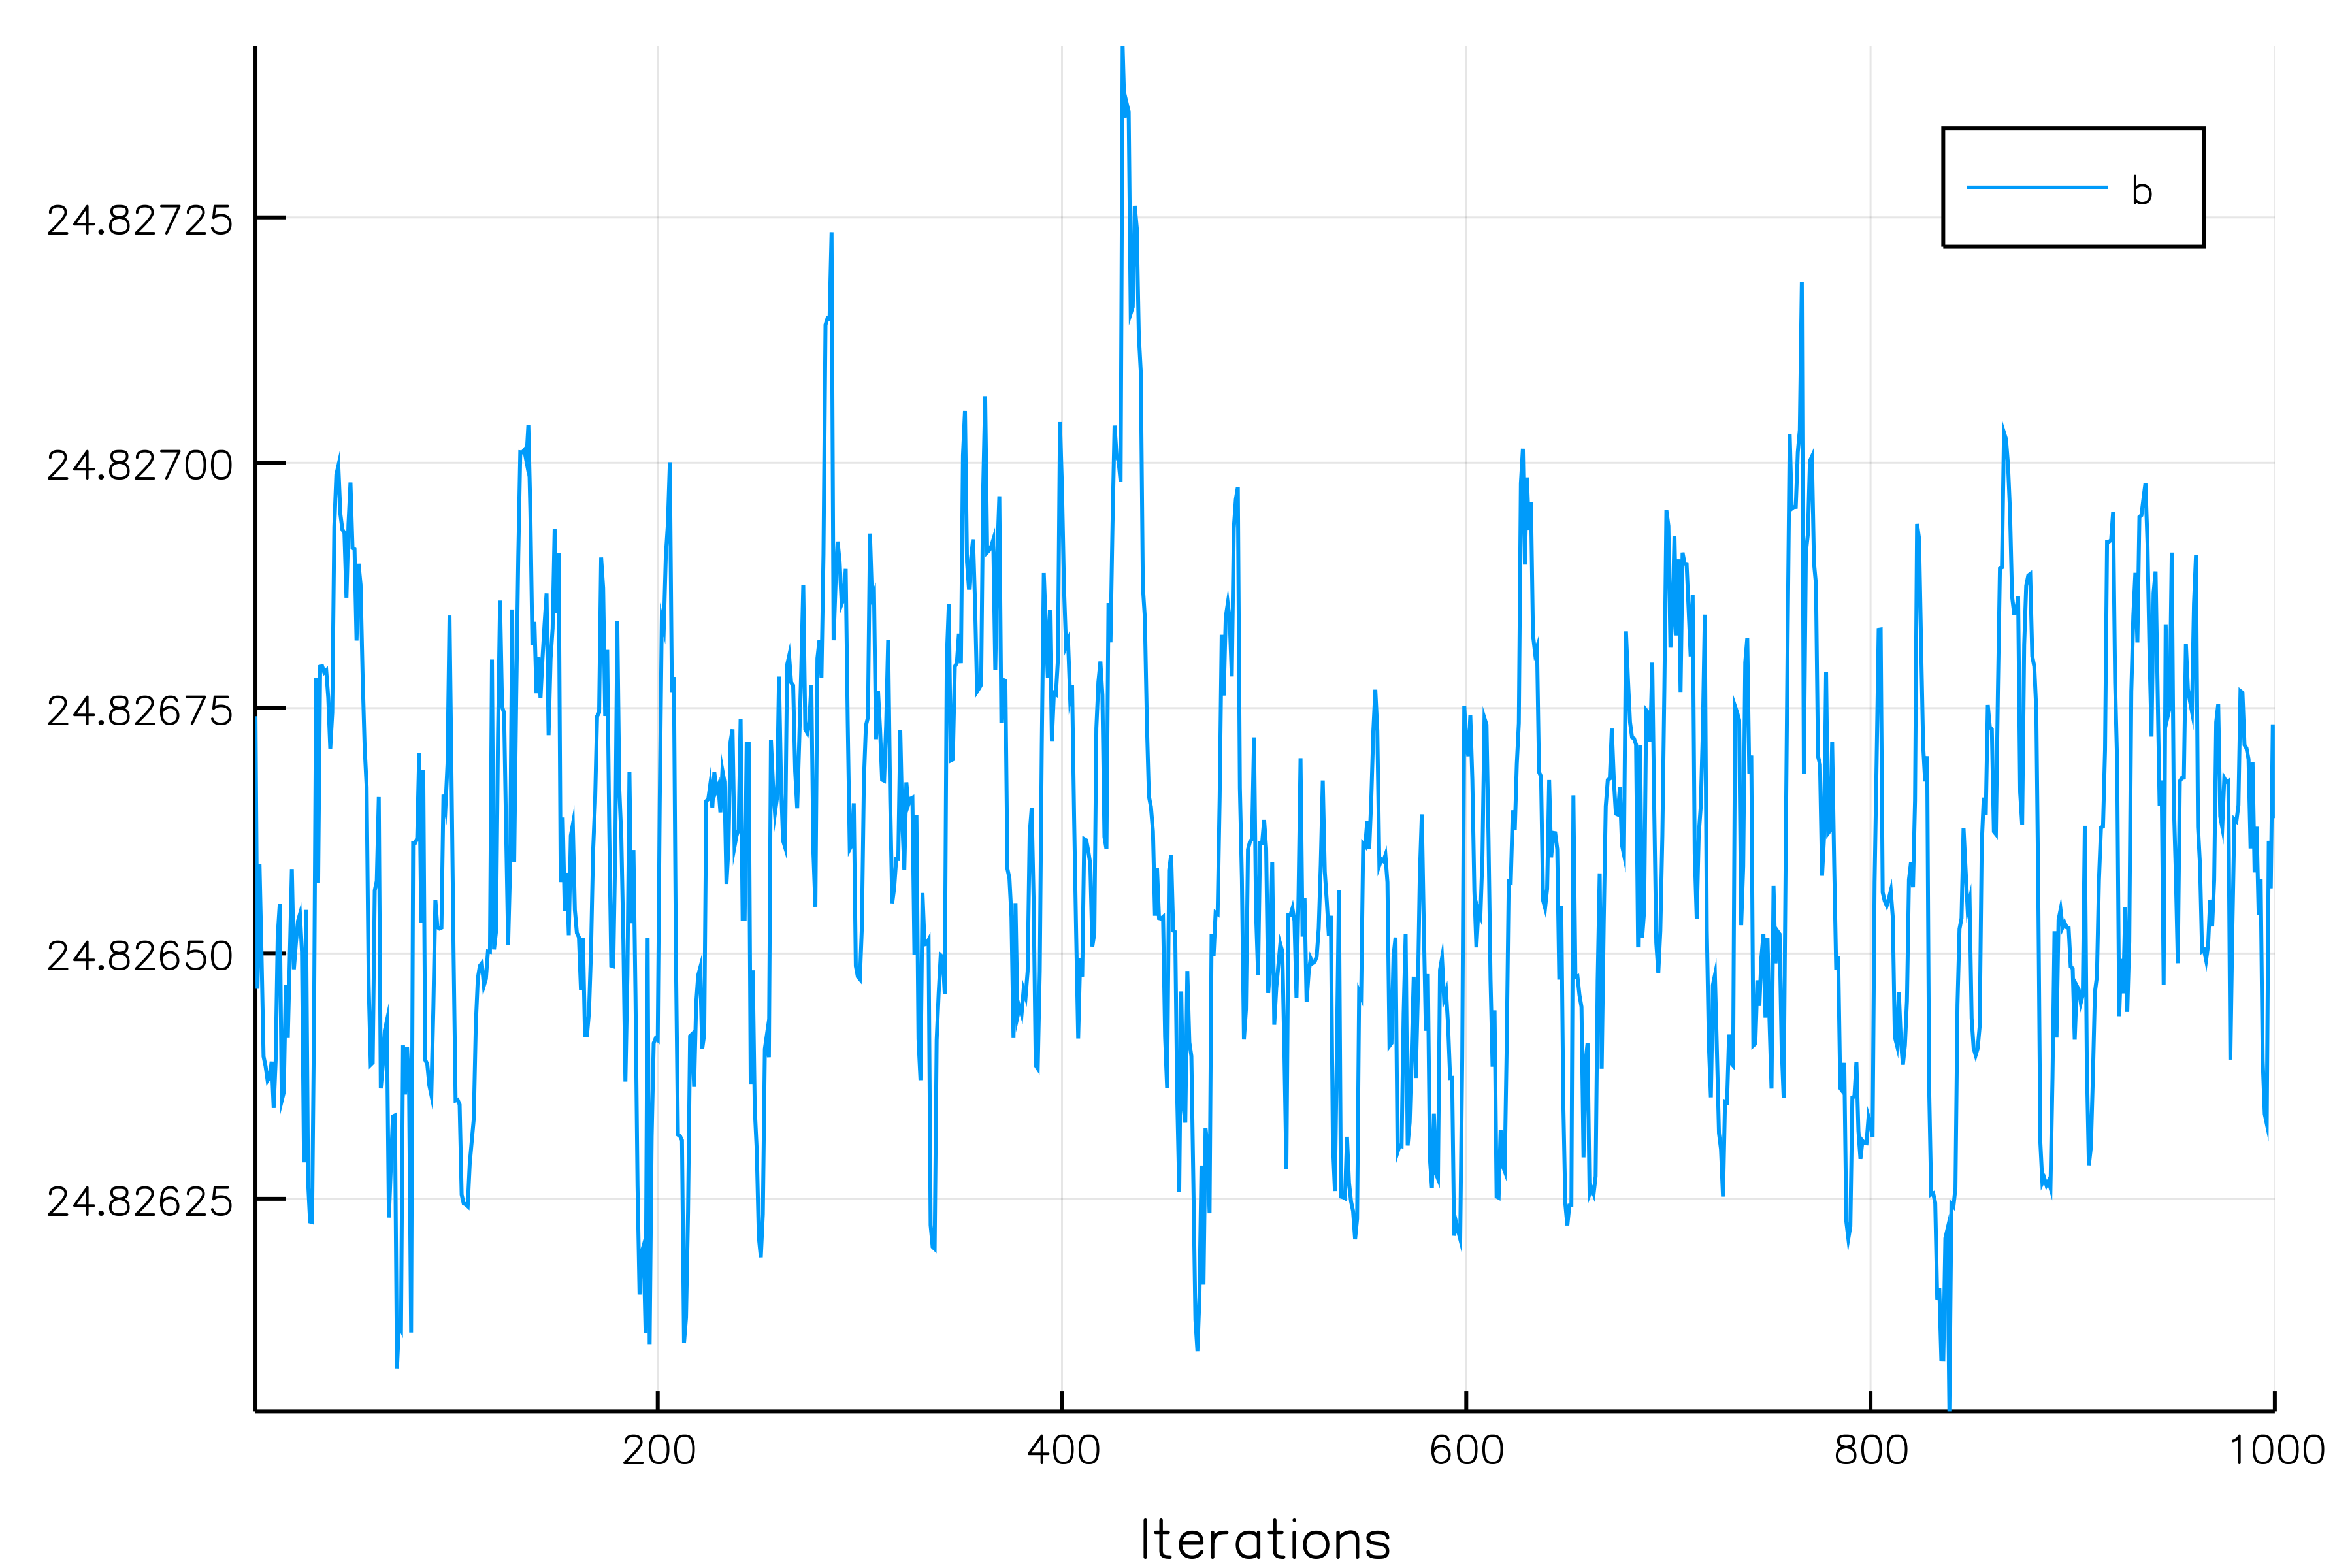

In [24]:
plot(bayesian_result[1][2], label="b",xlab= "Iterations")


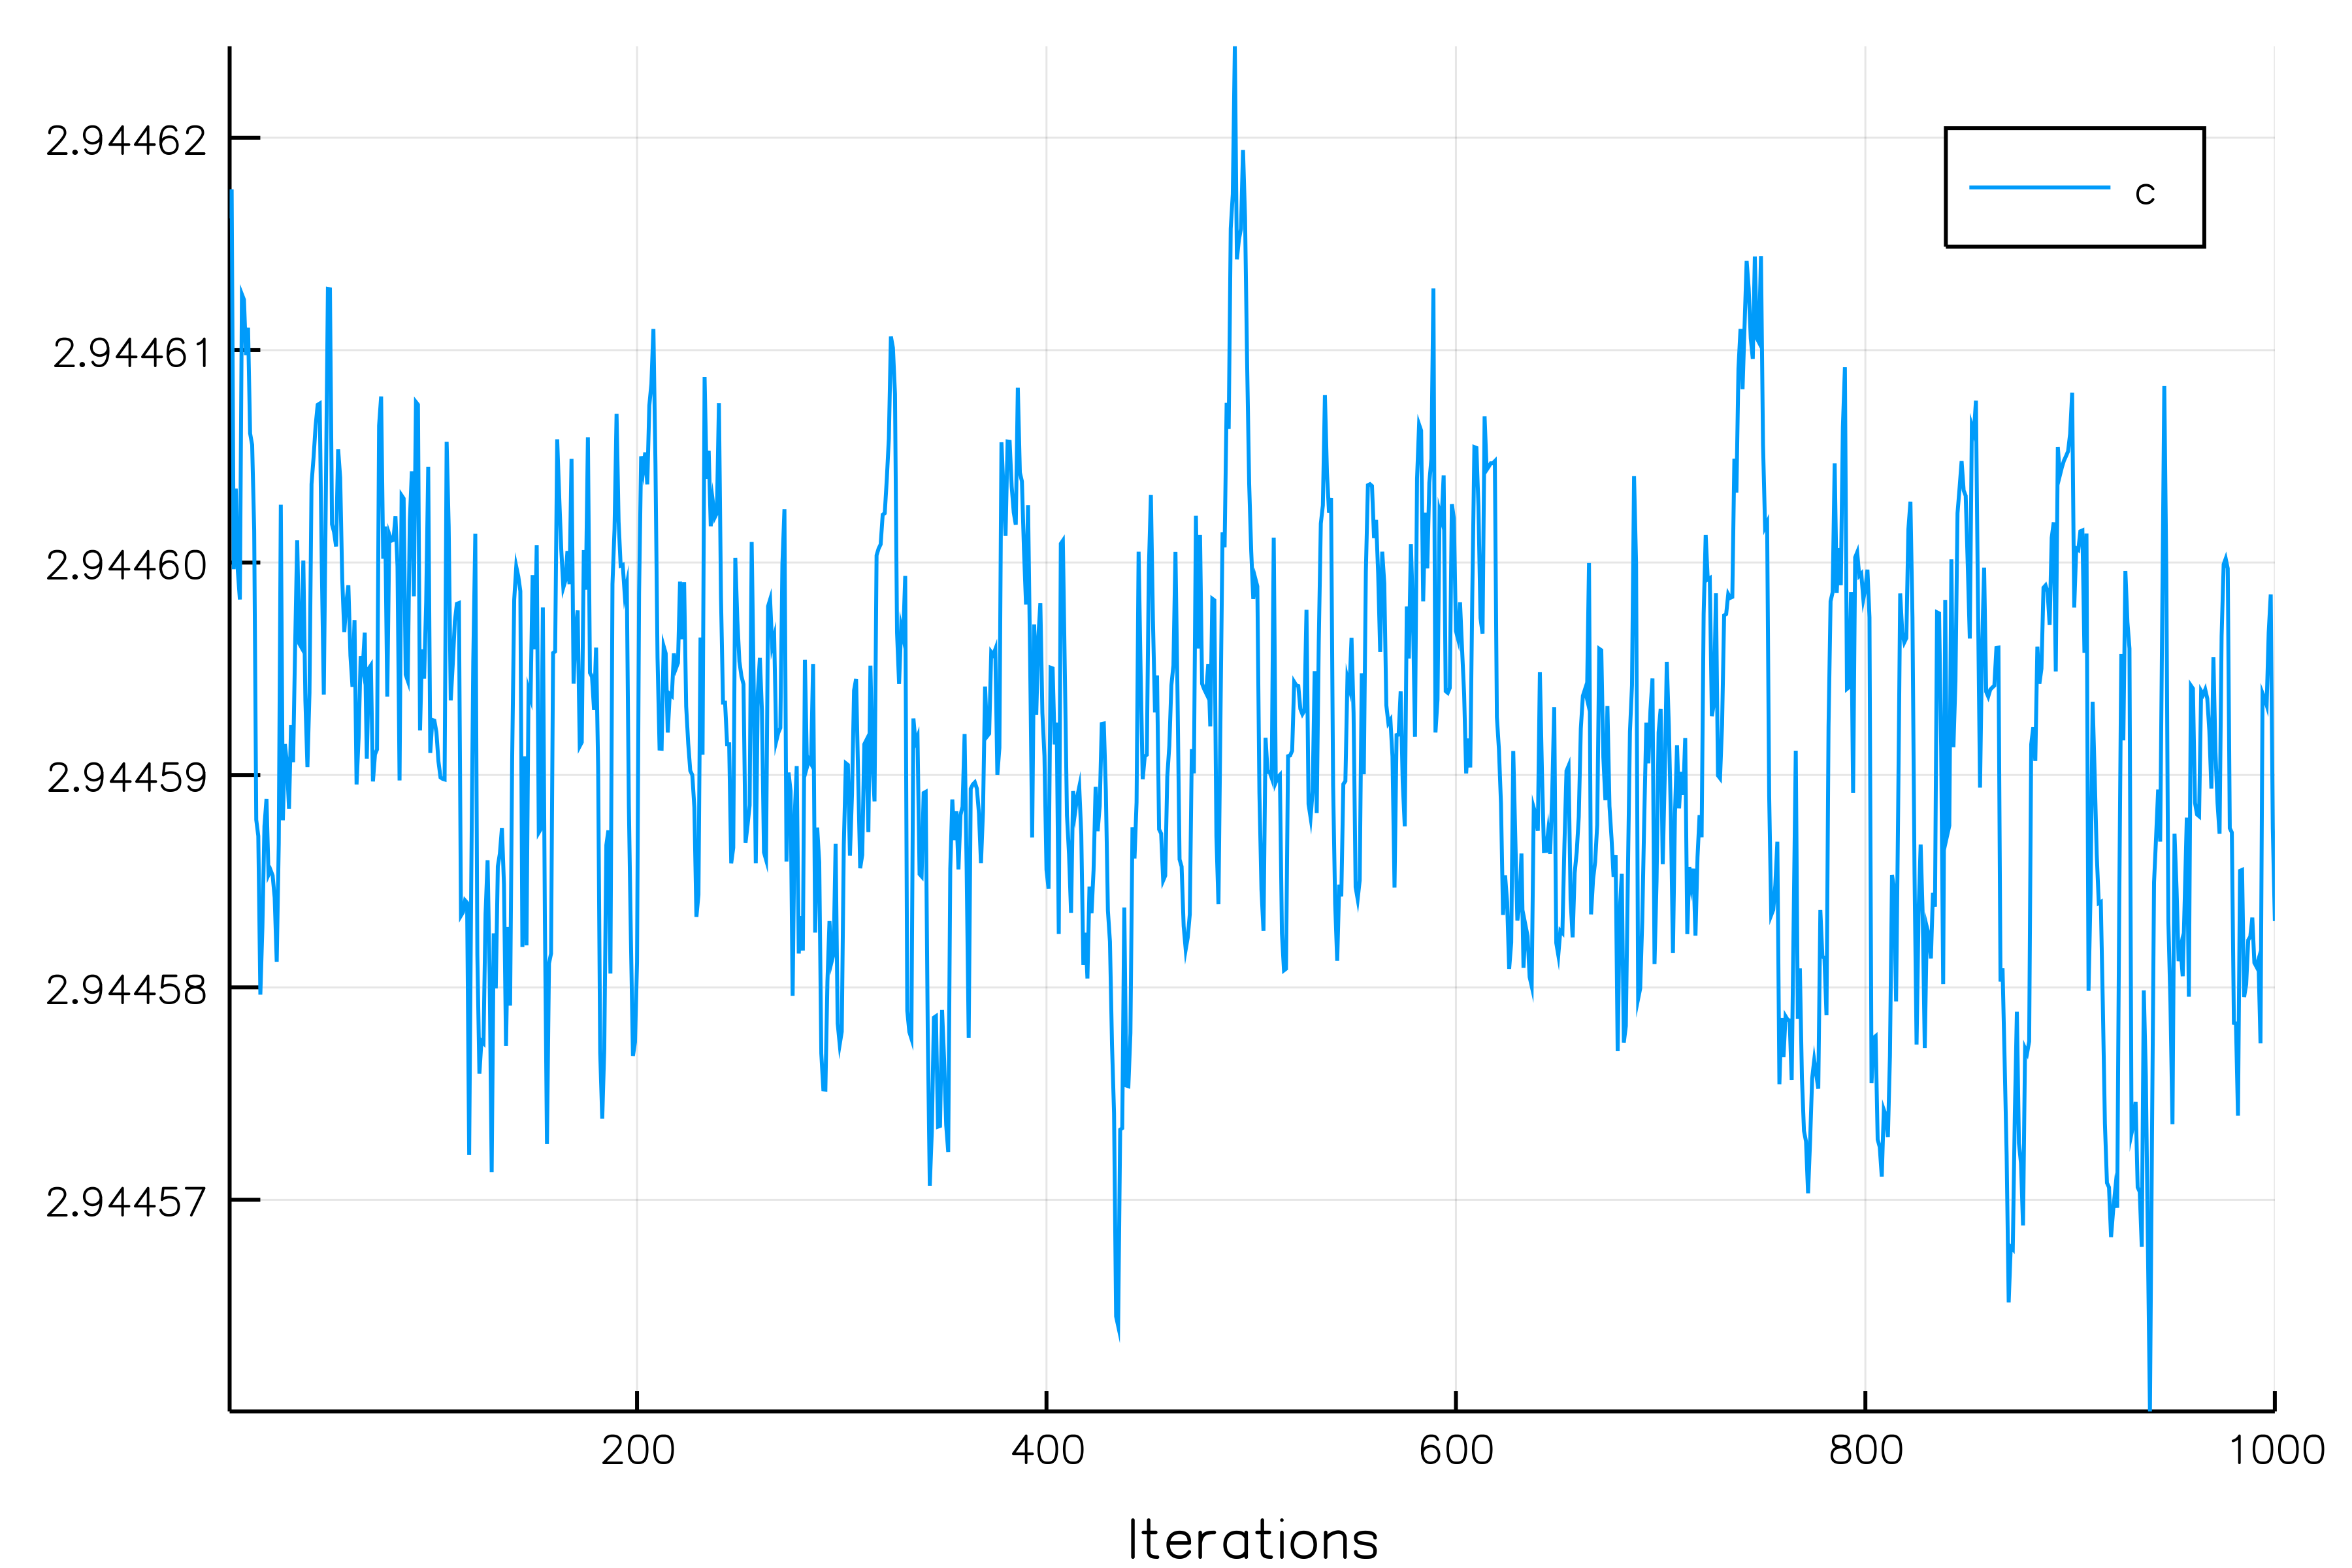

In [25]:
plot(bayesian_result[1][3], label="c", xlab= "Iterations")

## Conclusion

Due to the chaotic nature of Lorenz Equation, it is a very hard problem to estimate as it has the property of exponentially increasing errors. Its uncertainity plot points to its chaotic behaviour and goes awry for different values of tolerance, we use 1e-8 as the tolerance as it makes its uncertainity small enough to be trusted in `(0,30)` time span.

The behaviour is estimation using Stan.jl backend is as expected and it gives more accurate results as we decrease the tolerance, for 1e-8 we obtain quite accurate results as compared to higher tolerance values but lowering the tolerance leads to longer sampling time, incase of 1e-8 it took 11 hours. We also pass 500 warmup samples for proper convergence, as the plots provide evidence of non-convergence without it which observed over multiple runs.

DynamicHMC.jl backend takes significantly lesser time but also gives less accurate results, it took approximately 4 minutes in case of step size `0.001` and passed initial values. The accuracy can be increased by using different initial values and step sizes.